1: Import necessary libraries

In [4]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Reza.Gonabadi\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Reza.Gonabadi\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 985, in launch_instance
    app.start()
  File "c:\Users\Reza.Gonabadi\AppData\Local\Programs\Python\Python311\Lib\site-packages\ip

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

2: Load the radiomics CSV file

In [15]:
import os
import pandas as pd

# Define the output directories
output_directory = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_low_asus_Output"
output_directory_test = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_under80_Output"

# Path to the CSV files
radiomics_csv_path = os.path.join(output_directory, 'all_radiomics_features.csv')
radiomics_csv_path_test = os.path.join(output_directory_test, 'all_radiomics_features.csv')

# Read the CSV files into pandas DataFrames
radiomics_df = pd.read_csv(radiomics_csv_path)
radiomics_df_test = pd.read_csv(radiomics_csv_path_test)

# Remove rows from the training dataset that are present in the test dataset
patient_id_column = 'Patient_ID'  # Replace with the actual name of the Patient ID column
additional_patient_ids = radiomics_df_test[patient_id_column].unique()
radiomics_df = radiomics_df[~radiomics_df[patient_id_column].isin(additional_patient_ids)]

# Process the training dataset
# Extract the base identifier (e.g., "LIDC-IDRI-0001_nodule_1") from the "Mask" column
radiomics_df['Base_ID'] = radiomics_df['Mask'].str.extract(r'(LIDC-IDRI-\d+_nodule_\d+)')

# Count the number of annotations per Base_ID
annotation_counts = radiomics_df[radiomics_df['Mask'].str.contains('_annotation_', na=False)].groupby('Base_ID').size()

# Identify Base_IDs with more than one annotation
valid_base_ids = annotation_counts[annotation_counts > 1].index

# Filter the DataFrame to keep only "consensus" rows for valid Base_IDs
filtered_radiomics_df = radiomics_df[
    (radiomics_df['Base_ID'].isin(valid_base_ids)) & 
    (radiomics_df['Mask'].str.endswith('_consensus.nrrd', na=False))
]

# Drop the temporary 'Base_ID' column (optional)
filtered_radiomics_df = filtered_radiomics_df.drop(columns=['Base_ID'])

# Overwrite the original DataFrame with the filtered DataFrame
radiomics_df = filtered_radiomics_df

# Display the filtered DataFrame
print("Filtered Training Data:")
print(radiomics_df)

# Process the test dataset similarly
radiomics_df_test['Base_ID'] = radiomics_df_test['Mask'].str.extract(r'(LIDC-IDRI-\d+_nodule_\d+)')

# Count the number of annotations per Base_ID
annotation_counts_test = radiomics_df_test[radiomics_df_test['Mask'].str.contains('_annotation_', na=False)].groupby('Base_ID').size()

# Identify Base_IDs with more than one annotation
valid_base_ids_test = annotation_counts_test[annotation_counts_test > 1].index

# Filter the DataFrame to keep only "consensus" rows for valid Base_IDs
filtered_radiomics_df_test = radiomics_df_test[
    (radiomics_df_test['Base_ID'].isin(valid_base_ids_test)) & 
    (radiomics_df_test['Mask'].str.endswith('_consensus.nrrd', na=False))
]

# Drop the temporary 'Base_ID' column (optional)
filtered_radiomics_df_test = filtered_radiomics_df_test.drop(columns=['Base_ID'])

# Overwrite the test DataFrame with the filtered DataFrame
radiomics_df_test = filtered_radiomics_df_test

# Print the number of "consensus" rows in the test dataset
print("\nNumber of 'consensus' rows in the test dataset:")
print(len(radiomics_df_test))


Filtered Training Data:
          Patient_ID  Nodule_ID  \
0     LIDC-IDRI-0001          1   
5     LIDC-IDRI-0002          1   
10    LIDC-IDRI-0003          2   
15    LIDC-IDRI-0003          3   
20    LIDC-IDRI-0003          4   
...              ...        ...   
9388  LIDC-IDRI-1010          1   
9392  LIDC-IDRI-1011          1   
9397  LIDC-IDRI-1011          2   
9402  LIDC-IDRI-1011          3   
9409  LIDC-IDRI-1012          1   

                                                   Mask  \
0     C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
5     C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
10    C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
15    C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
20    C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
...                                                 ...   
9388  C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
9392  C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...   
9397  C:\Reza Gonabadi\P

3: Preprocess the data

In [16]:
# Assuming the 'Malignancy_Label' is the target column
target_column = 'Malignancy'  # Replace this with the actual name of your target column

# Filter the columns to keep only those that start with 'original_shape'
feature_columns = [col for col in radiomics_df.columns if 'original_shape' in col or 'firstorder' in col]

# Extract features (X) and target (y)
X = radiomics_df[feature_columns]
y = radiomics_df[target_column]

# If the target labels are categorical, we modify them to binary labels
# For 'Moderately Suspicious' and 'Highly Suspicious', label as 1, else 0
y = y.apply(lambda label: 1 if label in ['Moderately Suspicious', 'Highly Suspicious'] else 0)

# Check the first few rows to verify the feature extraction and target labeling
print(X.head())
print(y.head())


from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train = X
y_train = y

# Print the shapes of the training and testing sets to verify the split
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {y_train.shape}")

    original_shape_Elongation  original_shape_Flatness  \
0                    0.972560                 0.242197   
5                    0.918731                 0.643298   
10                   0.815524                 0.238987   
15                   0.686744                 0.248045   
20                   0.966797                 0.316844   

    original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                         7.854413                       32.429873   
5                        22.362177                       34.761745   
10                        6.960832                       29.126416   
15                        3.243108                       13.074666   
20                        4.681367                       14.774995   

    original_shape_Maximum2DDiameterColumn  \
0                                44.011362   
5                                42.190046   
10                               30.149627   
15                               10.049876   


4: Data Overview and Cleaning

In [4]:
# Check for missing values in the dataset
print("\nMissing Values in Features:")
print(X.isnull().sum())

print("\nMissing Values in Target Column:")
print(y.isnull().sum())

# Fill missing values with median
X.fillna(X.median(), inplace=True)

# Display summary statistics for the features
print("\nFeature Summary Statistics:")
print(X.describe())





Missing Values in Features:
original_shape_Elongation                 0
original_shape_Flatness                   0
original_shape_LeastAxisLength            0
original_shape_MajorAxisLength            0
original_shape_Maximum2DDiameterColumn    0
                                         ..
wavelet-LLL_firstorder_RootMeanSquared    0
wavelet-LLL_firstorder_Skewness           0
wavelet-LLL_firstorder_TotalEnergy        0
wavelet-LLL_firstorder_Uniformity         0
wavelet-LLL_firstorder_Variance           0
Length: 176, dtype: int64

Missing Values in Target Column:
0

Feature Summary Statistics:
       original_shape_Elongation  original_shape_Flatness  \
count                1695.000000              1695.000000   
mean                    0.772792                 0.391431   
std                     0.126600                 0.177648   
min                     0.259786                 0.000000   
25%                     0.701263                 0.258172   
50%                     0.7961

C:\Users\Reza.Gonabadi\AppData\Local\Temp\ipykernel_11912\3568851668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


5: Target Column Distribution

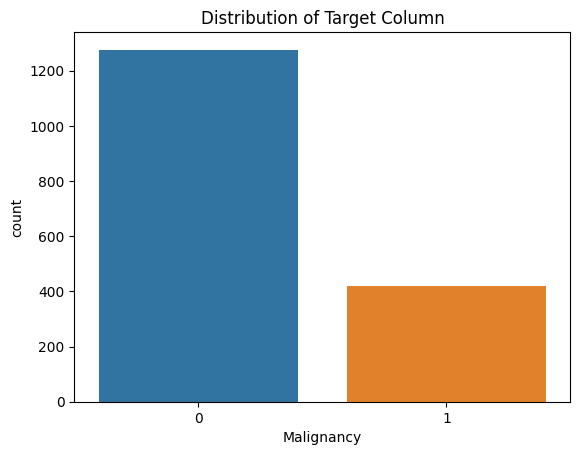


Class Distribution in Target Column:
Malignancy
0    0.752802
1    0.247198
Name: proportion, dtype: float64


In [5]:
# Check the distribution of the target column
sns.countplot(x=y)
plt.title('Distribution of Target Column')
plt.show()

# Print the proportion of each class
print("\nClass Distribution in Target Column:")
print(y.value_counts(normalize=True))



Forward Selection

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

# Use Logistic Regression for faster feature selection
lr = LogisticRegression(max_iter=1000, random_state=42)
forward_selector = SequentialFeatureSelector(
    lr, n_features_to_select=10, direction='forward', scoring='accuracy', cv=5, n_jobs=-1
)
forward_selector.fit(X_train, y_train)


# Get selected feature names
forward_selected_features = X_train.columns[forward_selector.get_support()]
print("\nForward Selected Features:")
print(forward_selected_features)

# Create new datasets with selected features
X_train_forward = X_train[forward_selected_features]



Forward Selected Features:
Index(['original_shape_LeastAxisLength', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_firstorder_Variance',
       'wavelet-LLH_firstorder_Maximum', 'wavelet-LLH_firstorder_Median',
       'wavelet-HLL_firstorder_Skewness',
       'wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation',
       'wavelet-HHL_firstorder_Minimum', 'wavelet-HHH_firstorder_Uniformity'],
      dtype='object')


MRMR (Minimum Redundancy Maximum Relevance)

In [7]:
from sklearn.feature_selection import mutual_info_classif
from mrmr import mrmr_classif  # Install mrmr library via pip if not already installed

# Compute MRMR-selected features
mrmr_selected_features = mrmr_classif(
    X=X_train, y=y_train, K=10  # Select top 10 features
)
print("\nMRMR Selected Features:")
print(mrmr_selected_features)

# Create new datasets with MRMR-selected features
X_train_mrmr = X_train[mrmr_selected_features]


100%|██████████| 10/10 [00:00<00:00, 31.43it/s]


MRMR Selected Features:
['original_shape_MinorAxisLength', 'wavelet-HHL_firstorder_Uniformity', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterColumn', 'original_shape_MajorAxisLength', 'original_shape_Maximum3DDiameter', 'original_shape_SurfaceVolumeRatio', 'original_shape_Sphericity', 'original_shape_SurfaceArea']


Recursive Feature Elimination (RFE)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Define the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Recursive Feature Elimination using Random Forest
rfe_selector = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe_selector.fit(X_train, y_train)

# Get selected feature names
rfe_selected_features = X_train.columns[rfe_selector.get_support()]
print("\nRFE Selected Features:")
print(rfe_selected_features)

# Create new datasets with RFE-selected features
X_train_rfe = X_train[rfe_selected_features]

# Optional: Display the transformed training set
print("\nTransformed Training Set (X_train_rfe):")
print(X_train_rfe.head())



RFE Selected Features:
Index(['original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_SurfaceArea',
       'original_shape_VoxelVolume', 'wavelet-HHH_firstorder_Maximum',
       'wavelet-HHH_firstorder_Skewness'],
      dtype='object')

Transformed Training Set (X_train_rfe):
    original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
0                        32.429873                               44.011362   
5                        34.761745                               42.190046   
10                       29.126416                               30.149627   
15                       13.074666                               10.049876   
20                       14.774995                               16.124515   

    original_shape_Maximum2DDiameterRow  \
0  

LASSO-Based Feature Selection

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# LASSO-based feature selection
lasso = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_train, y_train)

# Get selected feature names
lasso_selected_features = X_train.columns[lasso.coef_[0] != 0]
print("\nLASSO Selected Features:")
print(lasso_selected_features)

# Create new datasets with LASSO-selected features
X_train_lasso = X_train[lasso_selected_features]




LASSO Selected Features:
Index(['original_shape_Maximum3DDiameter', 'original_shape_SurfaceArea',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_Energy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_TotalEnergy', 'original_firstorder_Variance',
       'wavelet-LLH_firstorder_10Percentile',
       'wavelet-LLH_firstorder_90Percentile', 'wavelet-LLH_firstorder_Energy',
       'wavelet-LLH_firstorder_InterquartileRange',
       'wavelet-LLH_firstorder_Kurtosis', 'wavelet-LLH_firstorder_Maximum',
       'wavelet-LLH_firstorder_Mean', 'wavelet-LLH_firstorder_Median',
       'wavelet-LLH_firstorder_Range',
       'wavelet-LLH_firstorder_RootMeanSquared',
       'wavelet-LLH_firstorder_TotalEnergy', 'wavelet-LLH_firstorder_Variance',
       'wavelet-LHL_firstorder_90Percentile', 'wavelet-LHL_firstorder_Energy',
       'wavelet-LHL_firstorder_Kurto

NOVVA Score (Approximation with Mutual Information)

In [11]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

def novva_score(X, y):
    """
    Approximate NOVVA score using mutual information and normalization.
    X: Feature DataFrame
    y: Target Series
    Returns: DataFrame of features and their NOVVA scores
    """
    # Compute mutual information scores
    mi_scores = mutual_info_classif(X, y)
    mi_scaled = MinMaxScaler().fit_transform(mi_scores.reshape(-1, 1)).flatten()

    # Normalize scores (0-1 scale)
    novva_scores = pd.Series(mi_scaled, index=X.columns, name='NOVVA_Score')
    return novva_scores

# Compute NOVVA scores for features
novva_scores = novva_score(X_train, y_train)
print("\nNOVVA Scores:")
print(novva_scores.sort_values(ascending=False))

# Select top features based on NOVVA
top_novva_features = novva_scores.sort_values(ascending=False).head(10).index
X_train_novva = X_train[top_novva_features]




NOVVA Scores:
original_shape_SurfaceArea                            1.000000
original_shape_Maximum2DDiameterSlice                 0.967302
original_shape_MinorAxisLength                        0.950905
original_shape_Maximum2DDiameterColumn                0.923292
original_shape_VoxelVolume                            0.921228
                                                        ...   
wavelet-HHH_firstorder_MeanAbsoluteDeviation          0.000000
wavelet-LHH_firstorder_90Percentile                   0.000000
original_firstorder_10Percentile                      0.000000
wavelet-HHH_firstorder_90Percentile                   0.000000
wavelet-HHH_firstorder_RobustMeanAbsoluteDeviation    0.000000
Name: NOVVA_Score, Length: 176, dtype: float64


ICC (Intrinsic Correlation Coefficient)

In [12]:
def icc_score(X, y, top_k=5):
    """
    Compute ICC score based on correlation and relevance.
    X: Feature DataFrame
    y: Target Series
    top_k: Number of features to select
    Returns: List of selected features
    """
    # Compute relevance (correlation with the target)
    relevance = X.apply(lambda col: np.corrcoef(col, y)[0, 1]).abs()

    # Compute redundancy (pairwise feature correlations)
    redundancy = X.corr().abs()

    selected_features = []
    for _ in range(top_k):
        # Choose the feature with the highest relevance among the remaining ones
        candidate_features = [f for f in X.columns if f not in selected_features]
        candidate_relevance = relevance[candidate_features]
        candidate_redundancy = redundancy.loc[candidate_features, selected_features].mean(axis=1) if selected_features else 0

        # ICC = Relevance - Redundancy
        icc_scores = candidate_relevance - candidate_redundancy
        best_feature = icc_scores.idxmax()
        selected_features.append(best_feature)

    return selected_features

# Compute ICC-selected features
icc_selected_features = icc_score(X_train, y_train, top_k=10)
print("\nICC Selected Features:")
print(icc_selected_features)

# Create new datasets
X_train_icc = X_train[icc_selected_features]




ICC Selected Features:
['original_shape_MinorAxisLength', 'wavelet-HHL_firstorder_Uniformity', 'original_shape_MajorAxisLength', 'wavelet-HLL_firstorder_Skewness', 'original_shape_SurfaceVolumeRatio', 'original_shape_Sphericity', 'wavelet-HHH_firstorder_Median', 'original_shape_Maximum2DDiameterRow', 'wavelet-LLH_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterColumn']


Feature Selection Using Gradient-Boosted Decision Trees (GBDT)

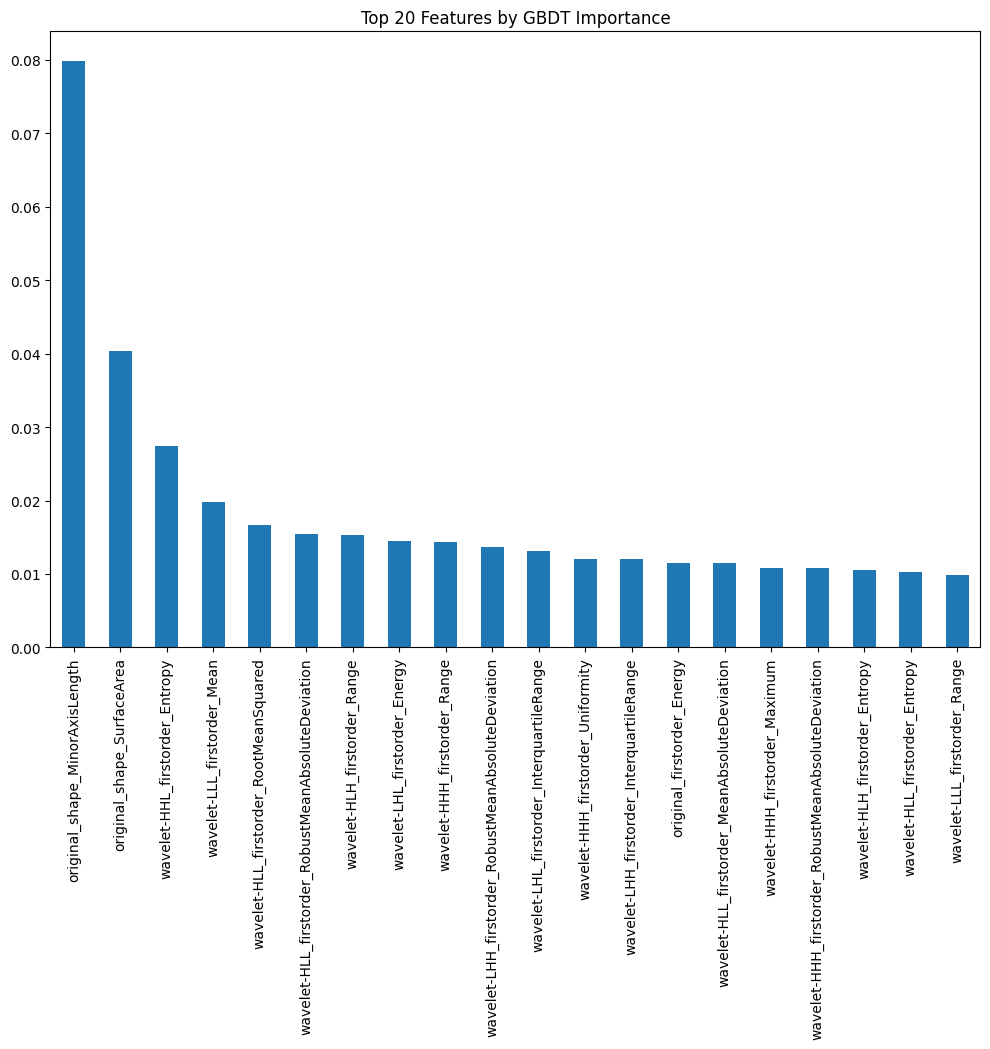


Top Features Selected by GBDT:
['original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'wavelet-HHL_firstorder_Entropy', 'wavelet-LLL_firstorder_Mean', 'wavelet-HLL_firstorder_RootMeanSquared', 'wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation', 'wavelet-HLH_firstorder_Range', 'wavelet-LHL_firstorder_Energy', 'wavelet-HHH_firstorder_Range', 'wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation']


In [13]:
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train an XGBClassifier on the training data
gbdt_clf = XGBClassifier(random_state=42)
gbdt_clf.fit(X_train, y_train)

# Extract feature importance
feature_importances = pd.Series(gbdt_clf.feature_importances_, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sorted_importances.head(20).plot(kind='bar', title="Top 20 Features by GBDT Importance")
plt.show()

# Select top N features (e.g., top 10 features)
top_n_features = sorted_importances.head(10).index.tolist()

# Reduce dataset to selected features
X_train_gbdt = X_train[top_n_features]


print("\nTop Features Selected by GBDT:")
print(top_n_features)


In [14]:
from collections import Counter

# Your feature lists (example lists provided, replace with your actual data)
feature_sets = {
    "forward_selected_features": forward_selected_features[:10],  # Ensure only the first 10
    "mrmr_selected_features": mrmr_selected_features[:10],
    "rfe_selected_features": rfe_selected_features[:10],
    "lasso_selected_features": lasso_selected_features[:10],
    "top_novva_features": top_novva_features[:10],
    "icc_selected_features": icc_selected_features[:10],
    "top_n_features": top_n_features[:10],
}

# Flatten all feature lists into a single list
all_features = [feature for features in feature_sets.values() for feature in features]

# Count occurrences of each feature
feature_counts = Counter(all_features)

# Display the most repetitive features (sorted by count)
most_repetitive_features = feature_counts.most_common()
print("\nMost Repetitive Features Across Feature Sets:")
for feature, count in most_repetitive_features:
    print(f"{feature}: {count} occurrences")



Most Repetitive Features Across Feature Sets:
original_shape_MinorAxisLength: 6 occurrences
original_shape_SurfaceArea: 5 occurrences
original_shape_Maximum2DDiameterRow: 4 occurrences
original_shape_Maximum2DDiameterColumn: 4 occurrences
original_shape_MajorAxisLength: 4 occurrences
original_shape_MeshVolume: 3 occurrences
original_shape_Maximum2DDiameterSlice: 3 occurrences
original_shape_Maximum3DDiameter: 3 occurrences
original_shape_SurfaceVolumeRatio: 3 occurrences
original_shape_VoxelVolume: 3 occurrences
original_firstorder_Variance: 2 occurrences
wavelet-HLL_firstorder_Skewness: 2 occurrences
wavelet-HHL_firstorder_Uniformity: 2 occurrences
original_shape_Sphericity: 2 occurrences
original_shape_LeastAxisLength: 1 occurrences
wavelet-LLH_firstorder_Maximum: 1 occurrences
wavelet-LLH_firstorder_Median: 1 occurrences
wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation: 1 occurrences
wavelet-HHL_firstorder_Minimum: 1 occurrences
wavelet-HHH_firstorder_Uniformity: 1 occurrences
wa